### `Prediction of Early Readmission Hospital of Diabetic patients`

### Exploratory Data analysis

In [743]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

from scipy.stats import iqr,zscore

In [744]:
data = pd.read_csv('diabetic_data.csv')
admission_type = pd.read_excel('Mapping.xlsx',sheet_name='Admission_type_id')
discharge_disposition = pd.read_excel('Mapping.xlsx',sheet_name='Discharge_disposition')
admission_source = pd.read_excel('Mapping.xlsx',sheet_name='Admission_source_id')

In [745]:
df = data.copy()

In [746]:
df.shape

(101766, 50)

In [747]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [748]:
df.iloc[:,0:10].head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2


In [749]:
df.iloc[:,10:19].head(3)

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1
0,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83
1,?,?,59,0,18,0,0,0,276
2,?,?,11,5,13,2,0,1,648


In [750]:
df.iloc[:,19:31].head(3)

,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide
0,?,?,1,None,None,No,No,No,No,No,No,No
1,250.01,255,9,None,None,No,No,No,No,No,No,No
2,250,V27,6,None,None,No,No,No,No,No,No,Steady


In [751]:
df.iloc[:,31:45].head(3)

,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone
0,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,Up,No,No,No
2,No,No,No,No,No,No,No,No,No,No,No,No,No,No


In [752]:
df.iloc[:,45:55].head(3)

,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,No,No,No,No,NO
1,No,No,Ch,Yes,>30
2,No,No,No,Yes,NO


In [753]:
df = df.rename(columns={'diag_1':'diagnosis_1','diag_2':'diagnosis_2','diag_3':'diagnosis_3'})

## Null values

In [754]:
def nullvalues(data):
    columns = data.columns.tolist()
    return {col : (data[col] == '?').sum() for col in columns if (data[col] == '?').sum() > 0}
null_dict = nullvalues(df)

print(null_dict)

null_df = pd.Series(null_dict).to_frame().reset_index().rename(columns={0:'Null_values'})

{'race': 2273, 'weight': 98569, 'payer_code': 40256, 'medical_specialty': 49949, 'diagnosis_1': 21, 'diagnosis_2': 358, 'diagnosis_3': 1423}


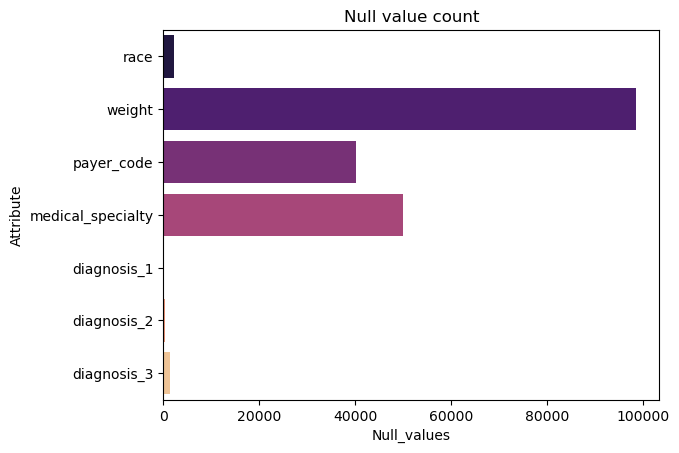

In [755]:
ax = sns.barplot(data=null_df,y='index',x='Null_values',palette='magma')
ax.set_title("Null value count")
plt.ylabel("Attribute")
plt.show()

In [756]:
df = df.replace(to_replace='?',value=np.nan)

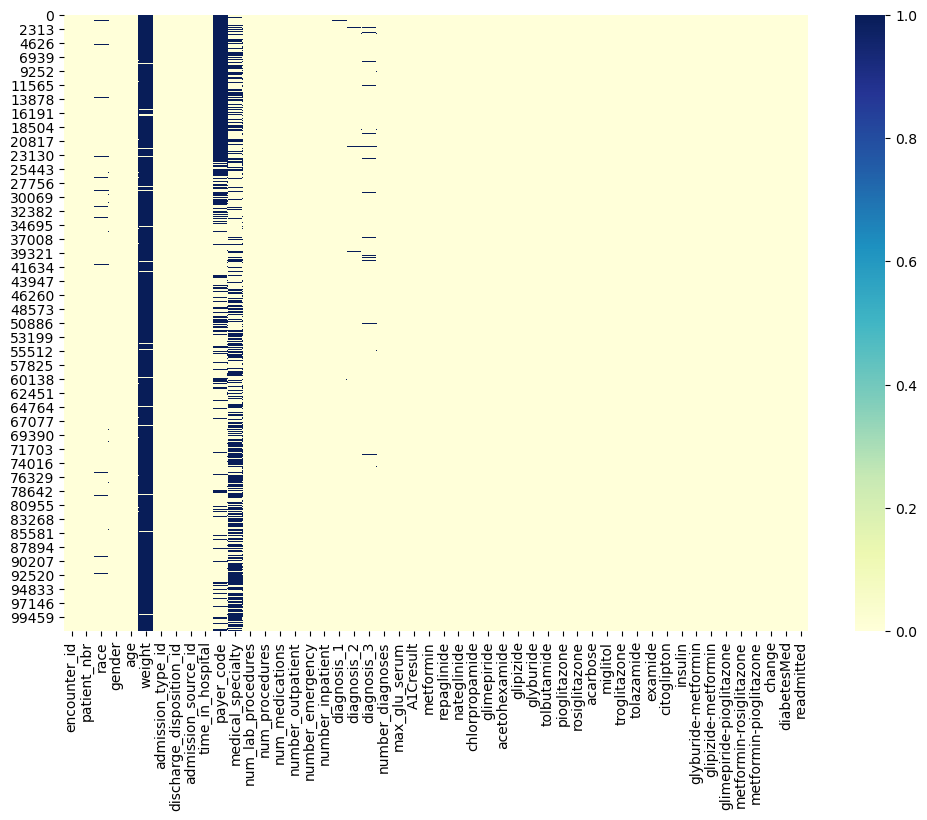

In [757]:
# Lets visualize null values

plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cmap='YlGnBu')
plt.show()

### Replacing '?' with 'NaN'

In [758]:
df.isin(['?']).sum()[df.isin(['?']).sum() > 0].count()

df.isnull().sum()[df.isnull().sum() > 0]

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diagnosis_1             21
diagnosis_2            358
diagnosis_3           1423
dtype: int64

In [759]:
def Description(data):
    """return dataframe of describing all Attributes
    """
    data_dict = {'Attribute' : data.columns,
                 'Data_type' : [data[column].dtype.name for column in data.columns],
                 'Total_Entries' : [data.shape[0]]*len(data.columns),
                 'Null_values' : data.isnull().sum().values,
                 'Percent_Null_values' : (data.isnull().mean().round(4) * 100).values,
                 'Unique_values' : data.nunique().values} 
    data_details = pd.DataFrame(data_dict)
    return data_details
data_desc = Description(df)

# Top 10 attributes which contain Null values

data_desc.sort_values(by=['Percent_Null_values'],ascending=False,ignore_index=True).head(20)

,Attribute,Data_type,Total_Entries,Null_values,Percent_Null_values,Unique_values
0,weight,object,101766,98569,96.86,9
1,medical_specialty,object,101766,49949,49.08,72
2,payer_code,object,101766,40256,39.56,17
3,race,object,101766,2273,2.23,5
4,diagnosis_3,object,101766,1423,1.40,789
5,diagnosis_2,object,101766,358,0.35,748
6,diagnosis_1,object,101766,21,0.02,716
7,encounter_id,int64,101766,0,0.00,101766
8,tolazamide,object,101766,0,0.00,3
9,glyburide,object,101766,0,0.00,4


In [760]:
# The attribute which does not give any information,which are going to be removed

data_desc[data_desc['Unique_values'] == 1]

,Attribute,Data_type,Total_Entries,Null_values,Percent_Null_values,Unique_values
39,examide,object,101766,0,0.0,1
40,citoglipton,object,101766,0,0.0,1


In [761]:
data_desc.sort_values(by=['Unique_values'],ignore_index=True).head(5)

,Attribute,Data_type,Total_Entries,Null_values,Percent_Null_values,Unique_values
0,examide,object,101766,0,0.0,1
1,citoglipton,object,101766,0,0.0,1
2,troglitazone,object,101766,0,0.0,2
3,acetohexamide,object,101766,0,0.0,2
4,tolbutamide,object,101766,0,0.0,2


In [762]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [763]:
df['readmitted'] = df['readmitted'].map({'<30':'Yes','>30':'No','NO':'No'})

## Race

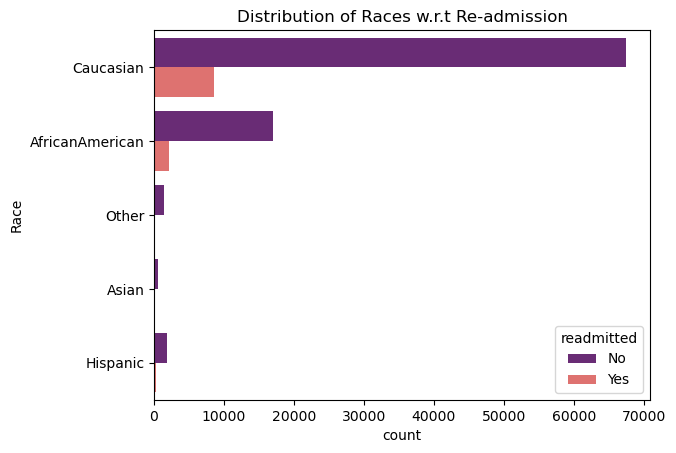

In [764]:
sns.countplot(y = df['race'],hue=df['readmitted'],palette='magma')
plt.title("Distribution of Races w.r.t Re-admission")
plt.ylabel("Race")
plt.show()

In [765]:
# from above plot, we can infer that caucasians and AfricanAmericans have 
# high re-admission rate

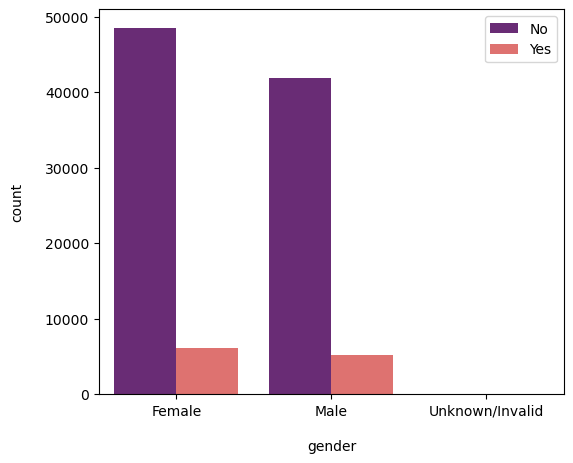

In [766]:
fig,ax = plt.subplots(figsize=(6,5))
sns.countplot(data=df,x='gender',hue=df['readmitted'],palette='magma')
plt.xlabel("gender",labelpad=15.0)
plt.ylabel("count",labelpad=15.0)
plt.legend(loc='upper right')
plt.show()

## Age

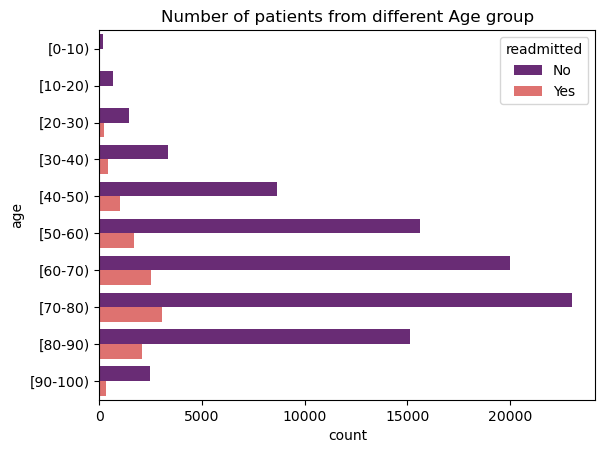

In [767]:
sns.countplot(y=df['age'],hue=df['readmitted'],palette='magma')
plt.title("Number of patients from different Age group")
plt.show()

In [768]:
# from above plot we can say most number of patients admissions are in the age range of 40-100
# people who are between age 70-80 have highest inpatient encounter as well as re-admission rate

In [769]:
# mapping 
# 1) Admission_type_id
# 2) Admission_source_id
# 3) Discharge_disposition_id

In [770]:
mapping_1 = dict(zip(discharge_disposition.discharge_disposition_id.values,
                     discharge_disposition.description.values))
mapping_2 = dict(zip(admission_type.admission_type_id.values,admission_type.description.values))
mapping_3 = dict(zip(admission_source.admission_source_id.values,
                     admission_source.description.values))

In [771]:
df.discharge_disposition_id = df.discharge_disposition_id.map(mapping_1).astype('string')
df.admission_type_id = df.admission_type_id.map(mapping_2).astype('string')
df.admission_source_id = df.admission_source_id.map(mapping_3).astype('string')

## Admission source

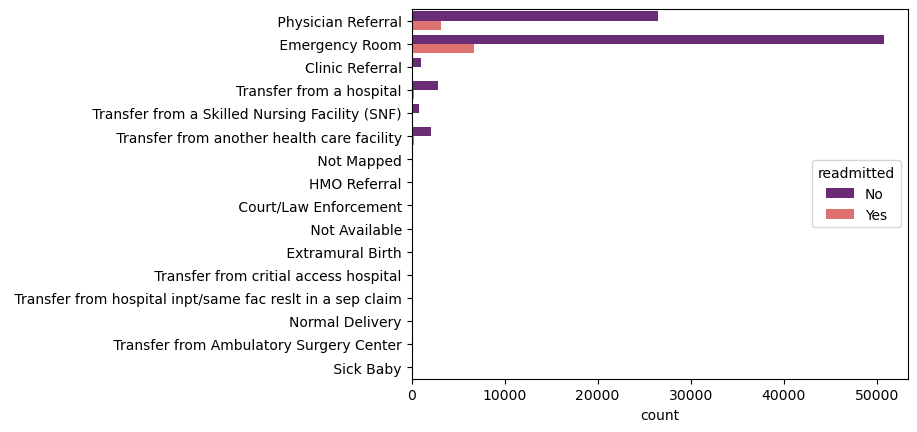

In [772]:
sns.countplot(y=df['admission_source_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.show()

## Admission type

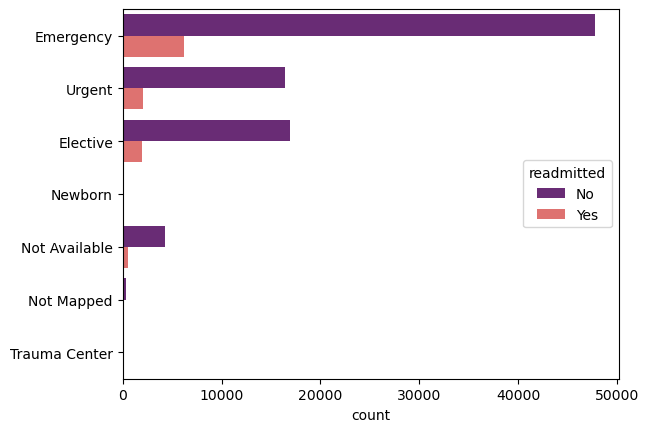

In [773]:
sns.countplot(y=df['admission_type_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.show()

## Discharge disposition

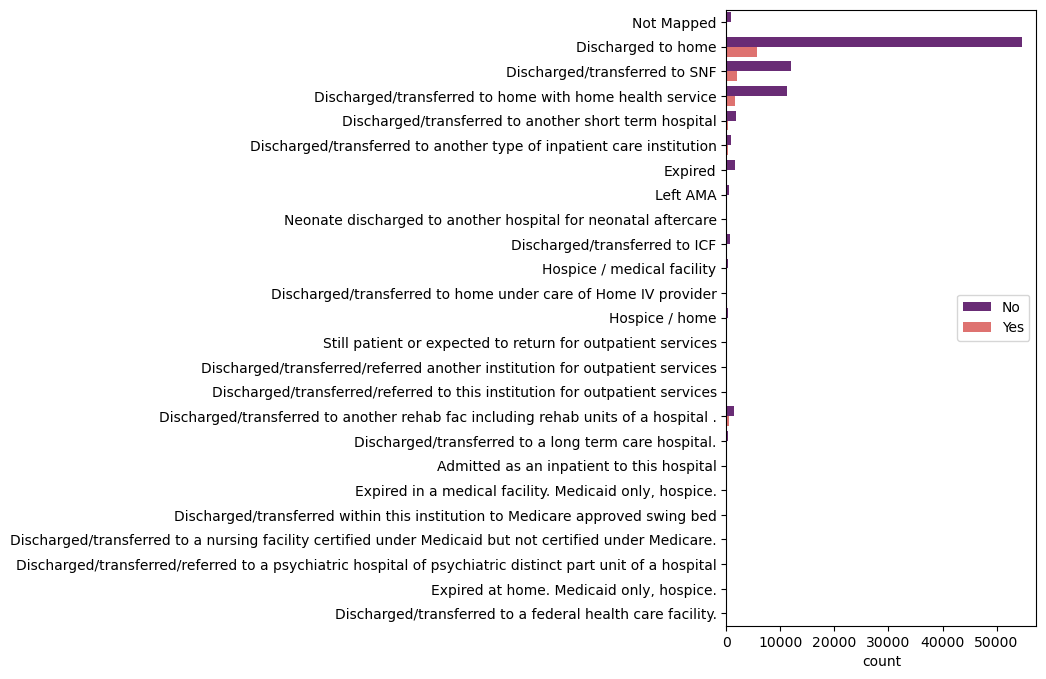

In [774]:
plt.figure(figsize=(4,8))
sns.countplot(y=df['discharge_disposition_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.legend(loc='center right')
plt.show()

## Time in hospital

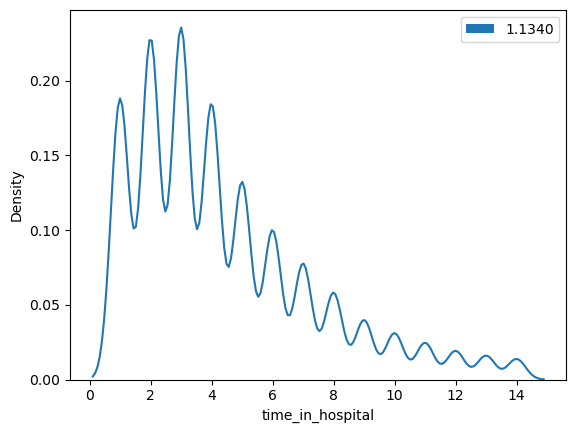

In [775]:
sns.kdeplot(df['time_in_hospital'])
skewness_time = f"{df['time_in_hospital'].skew():0.4f}"
kde_patch = mpatches.Patch(label=skewness_time)
plt.legend(handles=[kde_patch])
plt.show()

In [776]:
stats.shapiro(df['time_in_hospital'])

ShapiroResult(statistic=0.8869138360023499, pvalue=0.0)

## Medical speciality (Top 10)

In [777]:
# percentage null values in Medical speciality

np.round(df['medical_specialty'].isnull().sum()*100/df['medical_specialty'].shape[0],2)

49.08

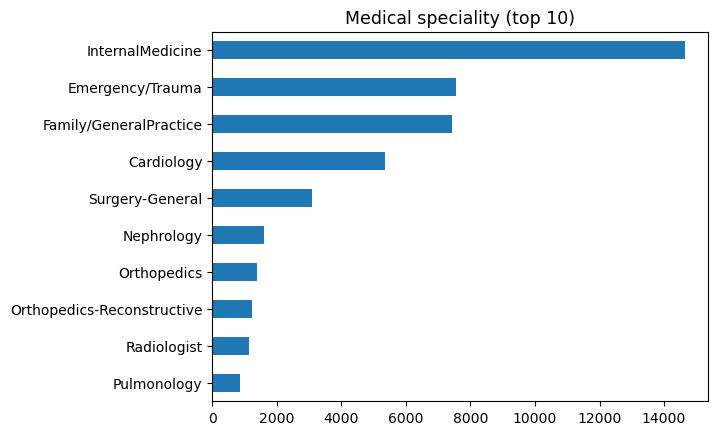

In [851]:
df.medical_specialty.value_counts().nlargest(10).sort_values().plot(kind='barh')
plt.title("Medical speciality (top 10)",fontsize=12.5)
plt.show()

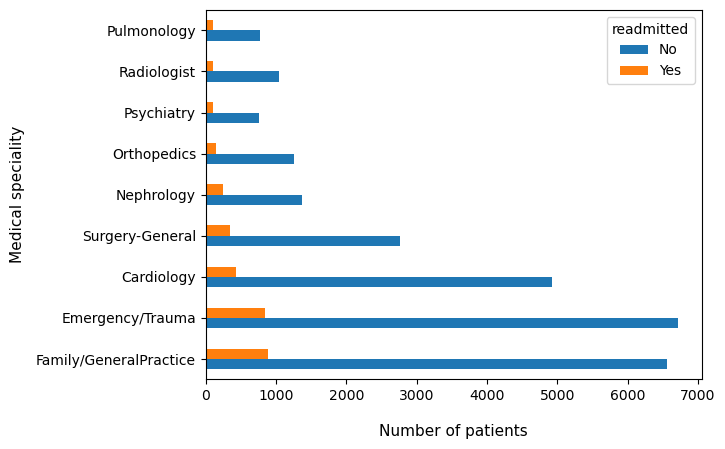

In [866]:
pd.crosstab(df['medical_specialty'],
            df['readmitted']).sort_values(by=['Yes'],ascending=0).iloc[1:10].plot(kind='barh')
plt.xlabel("Number of patients",fontsize=11,labelpad=15)
plt.ylabel("Medical speciality",fontsize=11,labelpad=8)
plt.show()

In [882]:
df[['medical_specialty','readmitted']]

,medical_specialty,readmitted
0,Pediatrics-Endocrinology,No
1,NaN,No
2,NaN,No
3,NaN,No
4,NaN,No
...,...,...
101761,NaN,No
101762,NaN,No
101763,NaN,No
101764,Surgery-General,No


In [779]:
fig,ax = plt.subplots(figsize=(5,4.5))
sns.countplot(df['medical_specialty'].sort_values())

## No of lab procedures

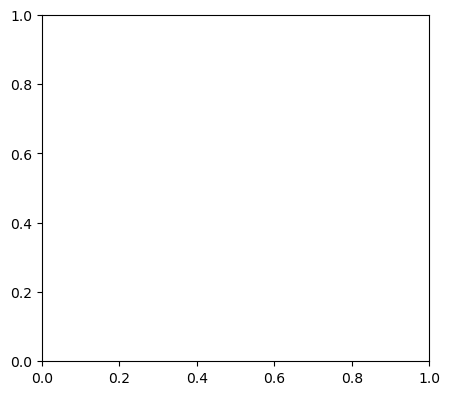

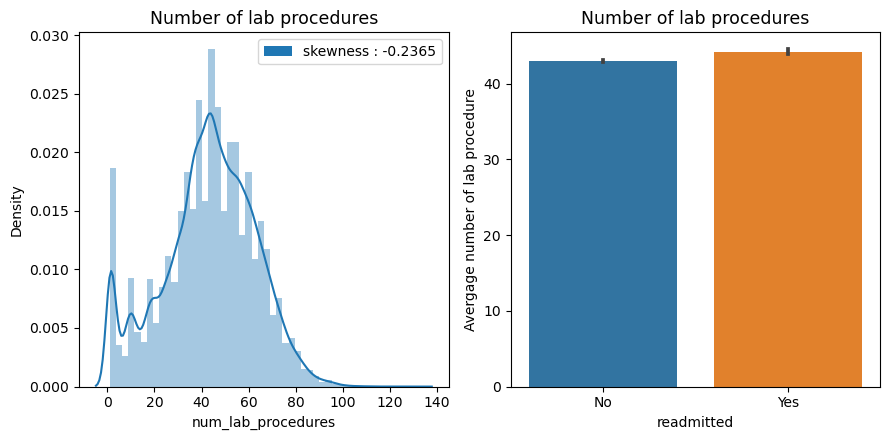

In [780]:
skewness_lab = f"skewness : {df['num_lab_procedures'].skew():0.4f}"
kde_patch_lab = mpatches.Patch(label=skewness_lab)

fig,ax = plt.subplots(1,2,figsize=(9,4.5))

sns.distplot(df['num_lab_procedures'],ax=ax[0])
ax[0].set_title("Number of lab procedures",fontsize=12.5)
ax[0].legend(handles=[kde_patch_lab])

sns.barplot(data=df,x='readmitted',y='num_lab_procedures',ax=ax[1])
ax[1].set_ylabel("Avergage number of lab procedure")
ax[1].set_title("Number of lab procedures",fontsize=12.5)

plt.tight_layout()
plt.show()

## No of procedures (Procedures other than lab procedures)

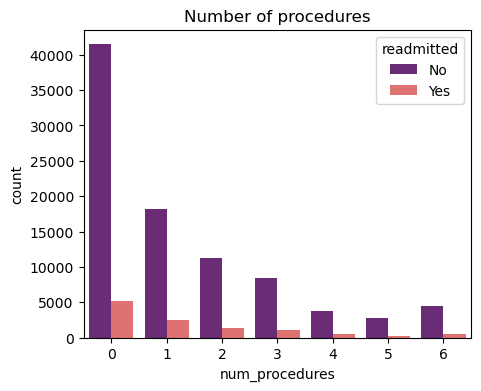

In [781]:
fig,ax = plt.subplots(figsize=(5,4))
ax = sns.countplot(df['num_procedures'],hue=df['readmitted'],palette='magma')
ax.set_title("Number of procedures")
plt.show()

## Number of Medications

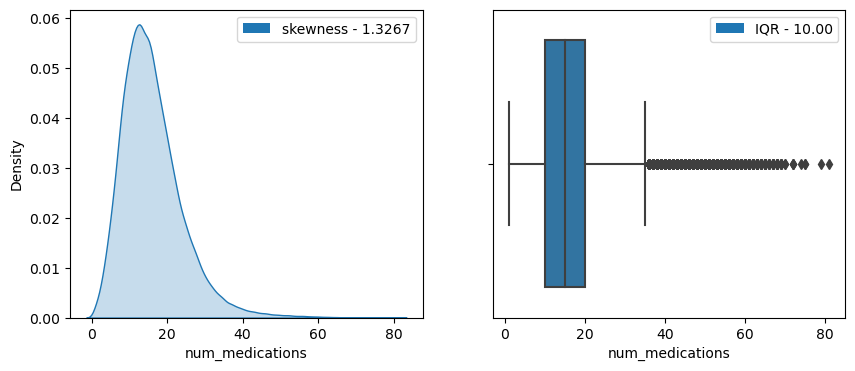

In [782]:
IQR = stats.iqr(df['num_medications'])
skewness = f"skewness - {df['num_medications'].skew():0.4f}"
IQR = f"IQR - {IQR:0.2f}"
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(df['num_medications'],ax=ax[0],fill=True)
kde_patch = mpatches.Patch(label=skewness)
box_patch = mpatches.Patch(label=IQR)
ax[0].legend(handles=[kde_patch])
ax[1].legend(handles=[box_patch])
sns.boxplot(df['num_medications'],ax=ax[1])
plt.show()

In [783]:
def outliers(dataframe,feature,criteria ='IQR',threshold = 1.5):
    """criteria={'IQR','zscore'} default IQR"""
    if criteria in ['IQR','Iqr','iqr']:
        upper_limit = np.quantile(dataframe[feature],0.75) + threshold*iqr(dataframe[feature])
        lower_limit = np.quantile(dataframe[feature],0.25) - threshold*iqr(dataframe[feature])
        dframe = dataframe[(dataframe[feature] < lower_limit) | (dataframe[feature] > upper_limit)]
        return dframe.index
    elif criteria in ['zscore','Zscore','z-score','Z-score','Z']:
        df_z = ((dataframe[feature] - dataframe[feature].mean())/dataframe[feature].std())
        return df[(df_z < (-1*threshold)) | (df_z > threshold)].index
    else:
        return "Mention correct criteria"

In [784]:
len(outliers(df,'num_medications'))

2557

## Inpatient & Outpatient encounters before present encounter
### (visualizing upto 6 visits)

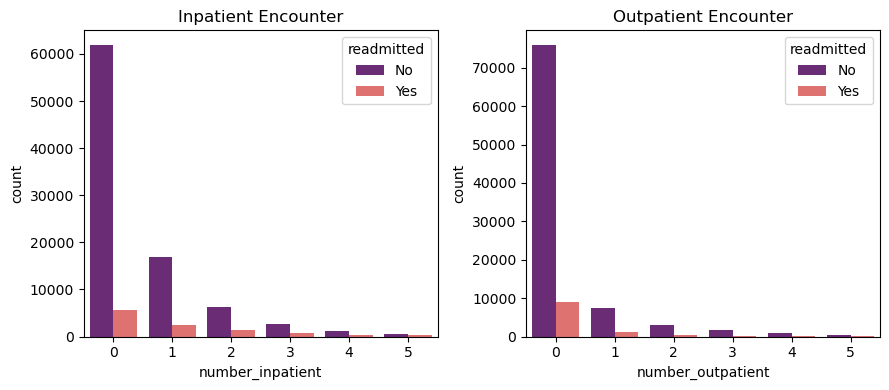

In [785]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
sns.countplot(df['number_inpatient'][df['number_inpatient'].isin([*range(6)])],
             hue=df['readmitted'],ax=ax[0],palette='magma')
ax[0].set_title("Inpatient Encounter")
ax[1].set_title("Outpatient Encounter")
sns.countplot(df['number_outpatient'][df['number_outpatient'].isin([*range(6)])],
             hue=df['readmitted'],ax=ax[1],palette='magma')
plt.tight_layout()
plt.show()

In [786]:
# Visualizing upto 5 Inpatient and outpatient encounters
# Since we are interested in only early re-admission rates (<30 days)
# Observations says 0 or 1 previous Inpatient encounters have high re-admission rate 
# Observations says 0 previous Outpatient encounters have high re-admission rate
# People having prior significant Inpatient/Outpatient encounters have less chance of getting readmitted 
# be it less than 30 days or greater than 30 days
# Hospital administration might have taken Post-Hospitalization steps to prevent re-admission
# But the early re-admission (<30) is a area of interest.

## Number of Emergency visits before the encounter

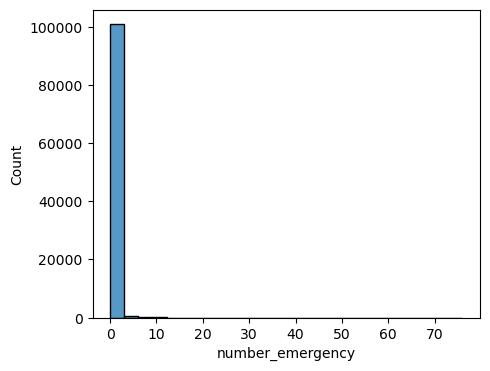

In [787]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.histplot(df['number_emergency'],bins=25)
plt.show()

## Diagnosis (1,2 & 3)

In [788]:
# Converting all strings to -1 to make attribute homogeneous
# Converting these columns to float64 datatype

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']
for diag in diagnosis:
    df[diag].loc[df[diag].astype('string').str.contains('[A-Za-z].+[0-9]*')] = -1
    df[diag] = df[diag].astype(np.float64)

In [789]:
def diagnosis_encoding(x):
    if (x >= 140 and x <= 239):
        return 'Neoplasms'
    elif x == 785 or (x >=390 and x <= 459):
        return 'circulatory'
    elif x == 786 or (x >= 460 and x <= 519):
        return 'Respiratory'
    elif x == 787 or (x >= 520 and x <= 579):
        return 'Digestive'
    elif x >= 250 and (x >= 250 and x <= 251):
        return 'Diabetes'
    elif x >= 800 and x <= 1000:
        return 'Injury'
    elif x >= 710 and x <= 739:
        return 'Musculoskeletal'
    elif (x >=580 and x <= 629) or x == 788: 
        return 'Genitourinary'
    elif x == -1:
        return 'other'
    elif pd.isnull(x):
        return np.nan
    else: 
        return 'other'

In [790]:
# Applying function to primary, secondary and Additional secondary diagnosis

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']
for diag in diagnosis:
    df[diag] = df[diag].apply(diagnosis_encoding)

In [791]:
# checking null values in primary diagnosis,secondary,Additional secondary diagnostics
imputation = ['diagnosis_1','diagnosis_2','diagnosis_3','readmitted']
df[imputation].isnull().sum()

diagnosis_1      21
diagnosis_2     358
diagnosis_3    1423
readmitted        0
dtype: int64

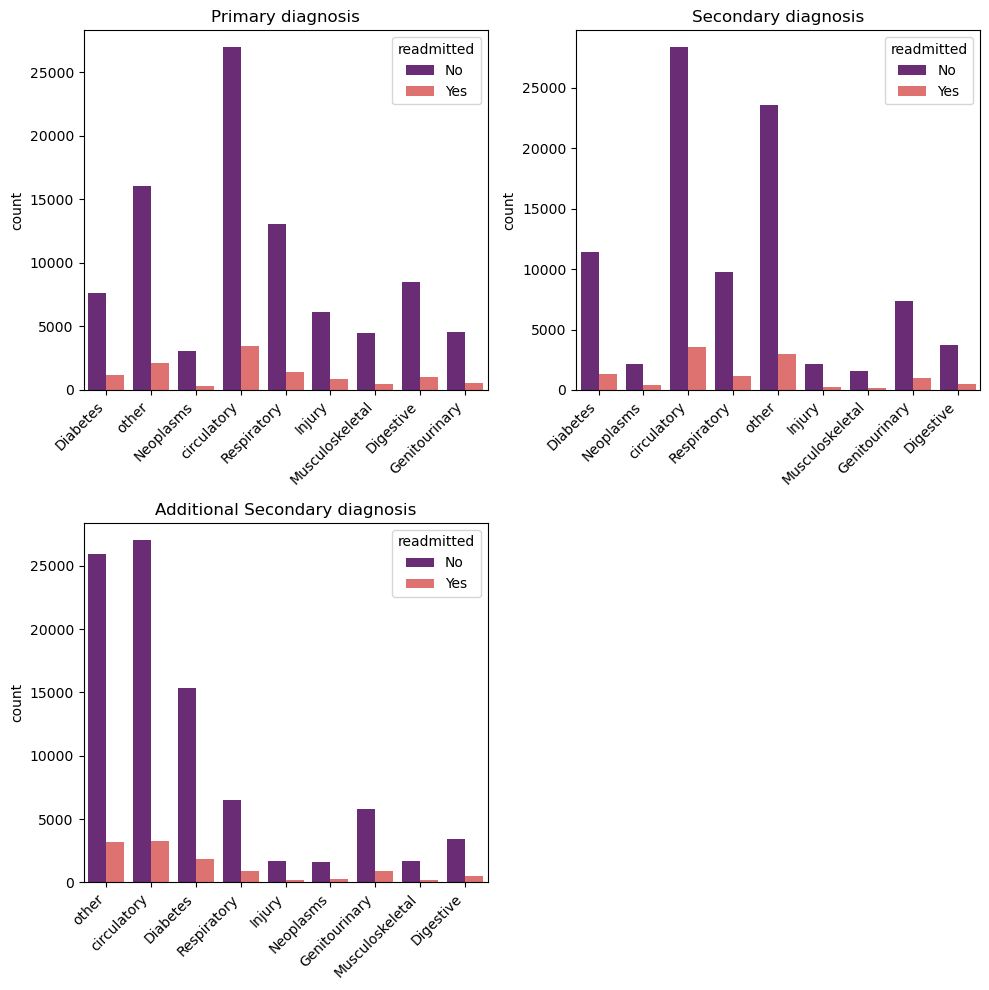

In [792]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.countplot(df['diagnosis_1'],hue=df['readmitted'],palette='magma')
plt.title("Primary diagnosis")
plt.xlabel("")
plt.xticks(rotation=45,ha='right')

plt.subplot(222)
sns.countplot(df['diagnosis_2'],hue=df['readmitted'],palette='magma')
plt.title("Secondary diagnosis")
plt.xticks(rotation=45,ha='right')
plt.xlabel("")

plt.subplot(223)
sns.countplot(df['diagnosis_3'],hue=df['readmitted'],palette='magma')
plt.title("Additional Secondary diagnosis")
plt.xticks(rotation=45,ha='right')
plt.xlabel("")

plt.tight_layout()
plt.show()

## Number of diagnosis

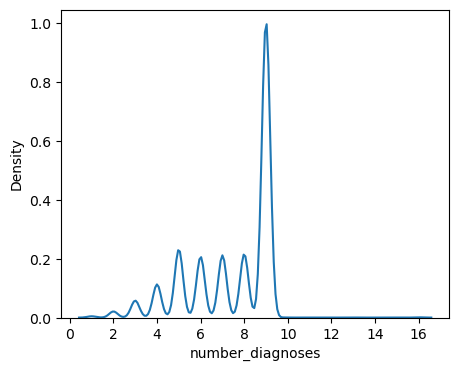

In [796]:
fig,ax = plt.subplots(figsize=(5,4))
sns.kdeplot(df['number_diagnoses'])
plt.show()

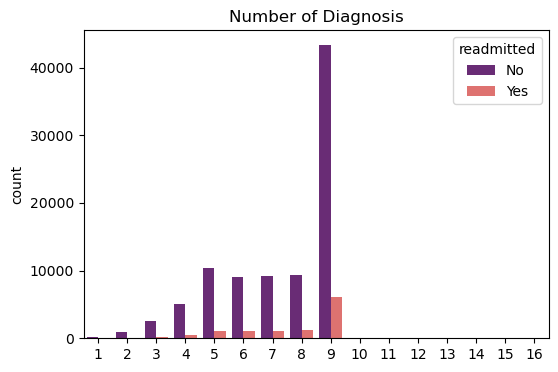

In [794]:
# Above data does not follow normality

plt.figure(figsize=(6,4))
sns.countplot(data=df,x='number_diagnoses',hue='readmitted',palette='magma')
plt.title("Number of Diagnosis")
plt.xlabel("")
plt.show()

## Max_glucose_serum

In [797]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

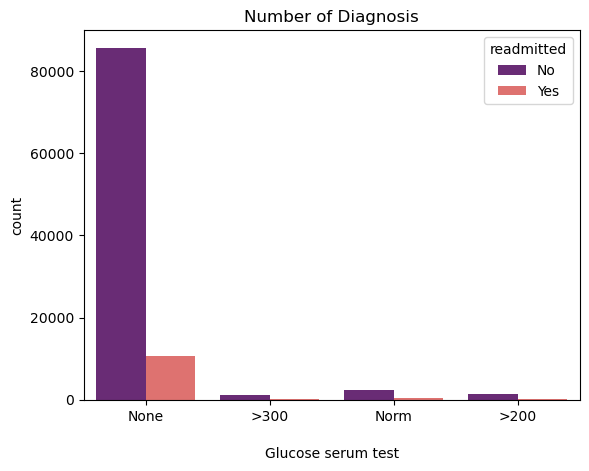

In [798]:
sns.countplot(df['max_glu_serum'],hue=df['readmitted'],palette='magma')
plt.title("Number of Diagnosis")
plt.xlabel("Glucose serum test",labelpad=17)
plt.show()

In [ ]:
# Inpatient encounters Glucose serum test has not been done, more cases of early re-admission

## A1c_result

In [ ]:
df['A1Cresult'].value_counts()

In [ ]:
sns.countplot(df['A1Cresult'],hue=df['readmitted'],palette='magma')
plt.show()

In [ ]:
# from above observation it shows that peope who have not undergone HBA1c test,
# they have high re-admission probability.
# also compared to '>7','Norm' the people who have '>8' HBA1c result have slightly higher
# readmission probability.

## Analysis of Medicine with respect to Admission

In [ ]:
# taking all attribute related to medicine, target - readmitted

medicine = df[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']]

In [ ]:
feature_medicine = medicine.columns

In [ ]:
# let us know categories in attributes related to Medicine
# constructing a dataframe by creating a dictionary except taregt.

med = dict()
for i in medicine.columns:
    med[i] = medicine[i].value_counts().to_dict()
medicine_info = pd.DataFrame(med).swapaxes(1,0)
medicine_info = medicine_info.fillna(0).astype(np.int32).rename({'No':'Not taking'},axis=1)

In [ ]:
medicine_info.columns

In [ ]:
def skewed_levels_row(row):    
    highlight = 'background-color: palegreen;'
    default = ''
    minimum_in_row = 5
    if row.sum() <= 5:
        return [highlight if v <= minimum_in_row else default for v in row]
    else:
        return [default for v in row]
medicine_info.style.apply(skewed_levels_row, subset=['Steady', 'Up', 'Down'], axis=1)

In [ ]:
# The numbers which are highlighted

In [ ]:
column_1 = lambda x : np.round((x.sum(axis=1)/medicine.shape[0]),2)*100
column_2 = np.round((medicine_info['Not taking']*100/medicine.shape[0]),2)

# creating 2 columns
medicine_info = medicine_info[['Steady','Up','Down']].assign(taking = column_1,not_taking=column_2)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
medicine_info[['taking','not_taking']].plot(kind='barh',stacked=True,color=['#C22D78','#EBD6CD'],ax=ax)

plt.xlabel("Percentage of patients",labelpad=15,fontsize=12)
plt.ylabel("Medicine",labelpad=13,fontsize=12)
plt.legend(loc=(1.05,0.85))
plt.show()

In [ ]:
# clearly we can see the zero values in some medicines which means 
# Some medicines are not at all taken by any patients.
# or very few value_counts, which will not give any information.

In [508]:
# steady, up & down means patient has consumed medicine
# since quantity is not given, combining categories
# steady,up & down.

## HBA1c

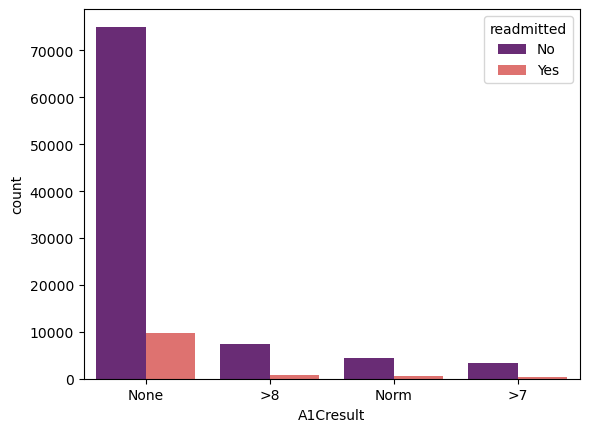

In [509]:
ordering = df['A1Cresult'].value_counts(ascending=False).index
sns.countplot(data=df,x='A1Cresult',hue=df['readmitted'],order=ordering,palette='magma')
plt.show()

In [510]:
# People who have not undergone HBA1c test are more likely to be readmitted to hospital.

## Change

In [511]:
# Change of diabetic medication

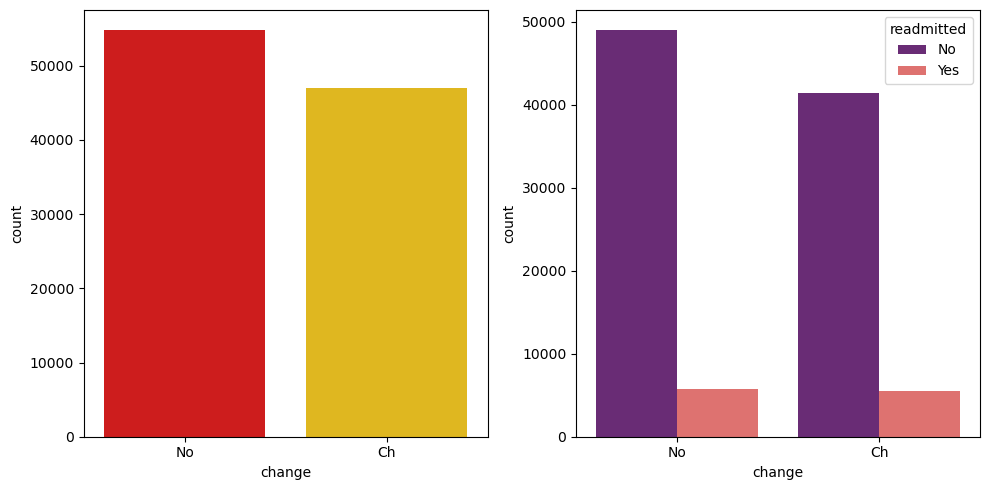

In [512]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.countplot(df['change'],palette='hot',ax=ax[0])
sns.countplot(df['change'],palette='magma',hue=df['readmitted'],ax=ax[1])
plt.tight_layout()
plt.show()

## HBA1c with change

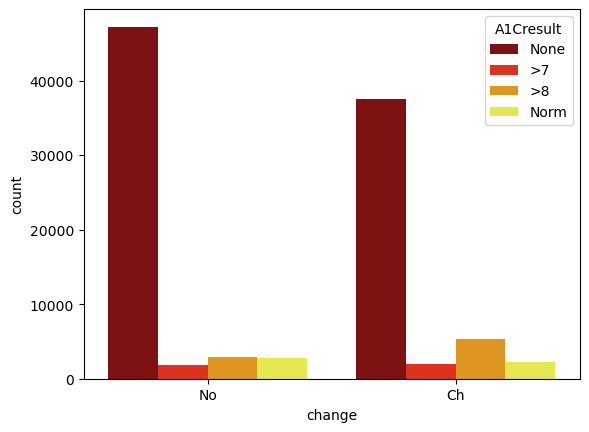

In [513]:
sns.countplot(df['change'],palette='hot',hue=df['A1Cresult'])
plt.show()

## Diabetes Med

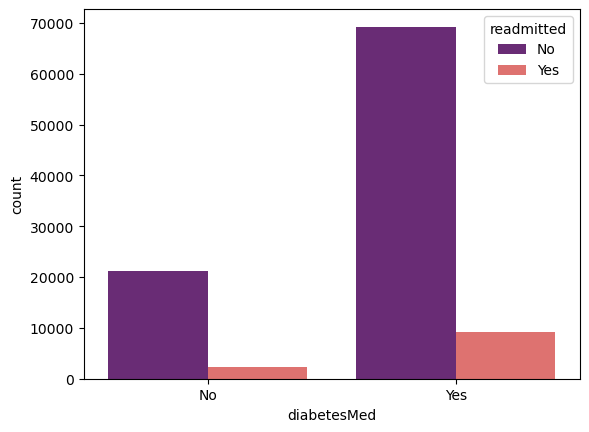

In [514]:
sns.countplot(df['diabetesMed'],palette='magma',hue=df['readmitted'])
plt.show()

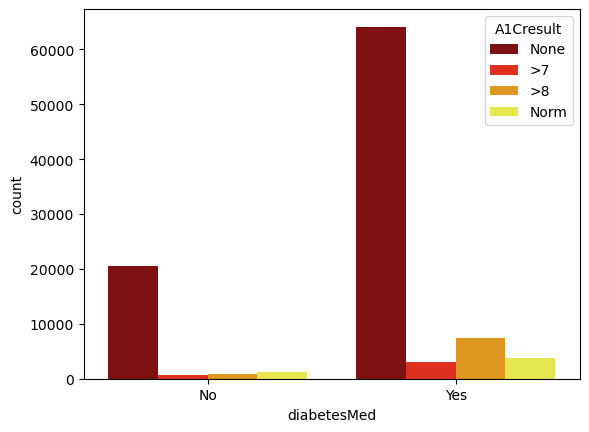

In [515]:
sns.countplot(df['diabetesMed'],palette='hot',hue=df['A1Cresult'])
plt.show()

In [516]:
# From above plot we can see that, people whose medications have been changed
# have high readmission chances

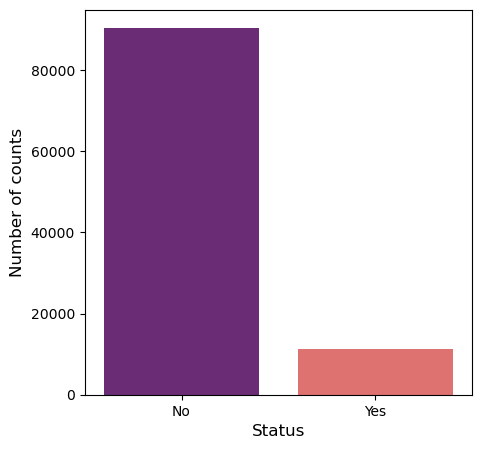

In [801]:
plt.figure(figsize=(5,5))
sns.countplot(df['readmitted'],palette='magma')
plt.ylabel("Number of counts",fontsize=12)
plt.xlabel("Status",fontsize=12)
plt.show()